In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import numpy.random as rand
from presto import psr_utils

In [2]:
def B_avg(DM, RM):
    DM = DM.value
    RM = RM.value
    return 1.23 * u.uG * RM / DM

def shift(prof, bin_shift):
    
    print(bin_shift)
    
    if bin_shift <= len(prof):
        shifted_prof = np.roll(prof, bin_shift)
        shifted_prof[:bin_shift] = np.zeros(bin_shift)

    else:
        return np.zeros(len(prof))

    return shifted_prof


def disperse(func, prof, DM, tsamp, nu, nu_ref, *P):
    """This function disperses a profile at a particular DM.
    Inputs:
    _______
            DM (float)    : DM of FRB

    Returns:
    ________
            dispersed_dspec: a smeared dynamic spectrum of the pulse
    """

    #define constants
    delay = func(DM, nu, nu_ref, *P)

    #calculate how much to shift bins
    dd_binshift = (delay // tsamp).astype('int')
    #print(dd_binshift)

    #apply dispersion delay to each spectral channel of 2D pulse profile
    dispersed_prof = shift(prof, dd_binshift)

    return dispersed_prof

In [3]:
def T1(n_e, nu, nu_ref):

    A = 3 / 4 / nu**2 / nu_ref**2
    #Rybicki and Lightman Eq 8.12
    nu_p = (5.63e4 * np.sqrt(n_e.value) * u.Hz / 2 / np.pi).to(u.MHz)
    B = nu_p**2 * (nu**2 + nu_ref**2)

    return A * B

def T2(B_para, nu, nu_ref):

    #Rybicki and Lightman Eq. 8.22a
    nu_c = (1.67e7 * (B_para.to(u.G)).value * u.Hz / 2 / np.pi).to(u.MHz)

    A = 2 * nu_c / nu / nu_ref
    B = (nu_ref**3 - nu**3) / (nu_ref**2 - nu**2)

    return A*B

def dt(DM, nu, nu_ref):

    kDM = 1/(2.41e-4) * u.MHz**2 * u.s * u.cm**3 / u.pc
    #calculate dispersion delay

    dt = kDM * DM * (1/nu**2 - 1/nu_ref**2)
    print(dt)
    return dt.to(u.us)

def dt_prime(DM, nu, nu_ref, n_e, B_para):

    kDM = 1/(2.41e-4) * u.MHz**2 * u.s * u.cm**3 / u.pc
    dt = kDM * DM * (1/nu**2 - 1/nu_ref**2) * (1 + T1(n_e, nu, nu_ref) + T2(B_para, nu, nu_ref))
    print(dt)
    return dt.to(u.ms)

In [4]:
Nchan = 4032 - 704
Npol = 4
Nbin = 1024
Nsub = 2.5*60


(Nchan * Npol * Nbin * 16/8 *Nsub * u.Hz).to(u.GHz)

<Quantity 4.0894464 GHz>

Bandwidth = 704 MHz to 4032 MHz

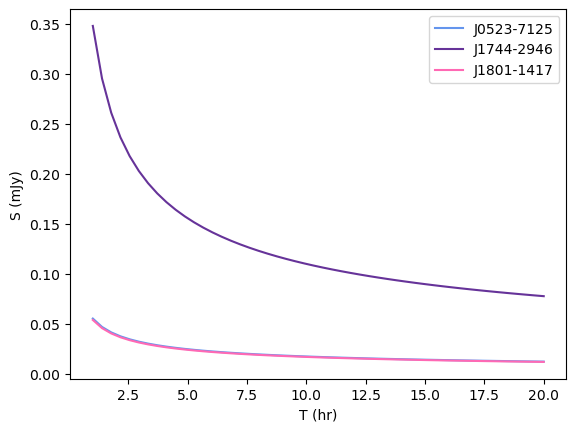

In [5]:
T_sys = 21 *u.K
T_skies = np.array([7.7, 214.87994, 33.944])*u.K
T_tots = T_sys + T_skies
G = 0.735 * u.K/u.Jy
BW = (4032 - 704)*u.MHz
P = (np.array([78.7, 8.4, 3.63])*u.ms).to(u.s)
w = np.array([0.3, 0.2, 0.1])
pulsars = ['J0523-7125', 'J1744-2946', 'J1801-1417']

Ts = np.linspace(3600*1, 3600*20)*u.s
colors = ['cornflowerblue', 'rebeccapurple', 'hotpink']

for i in range(3):

    fluxes = psr_utils.limiting_flux_dens(T_tots[i], G, BW, Ts, P[i], w[i], polar = 4).to(u.mJy)
    plt.plot(Ts.to(u.hr), fluxes, color = colors[i], label = pulsars[i])

plt.xlabel('T (hr)')
plt.ylabel('S (mJy)')
plt.legend()

In [6]:
longitude = 148.2621
latitude = -32.9986

In [7]:
def delta_DM(nu, dnu, w):

    return 0.52 * u.pc * u.cm**(-3) * w * nu**3 / dnu

Text(0.5, 1.0, 'DM tolernace for $\\Delta \\nu$ = 0.8 GHz')

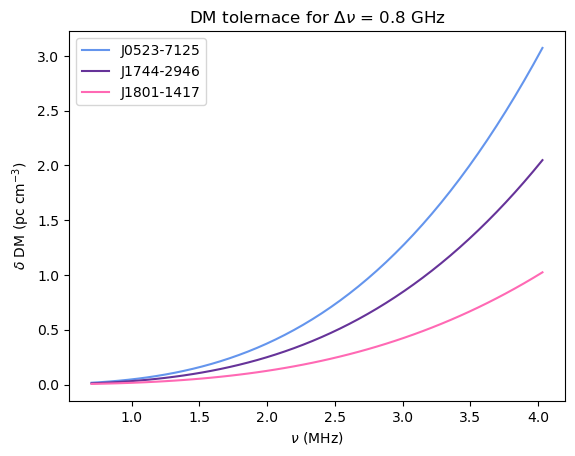

In [8]:
dnu = 4*0.832*u.GHz
#nu_low = 704
#nus = np.array([nu_low + dnu/2, nu_low + 3*dnu / 2, nu_low + 5*dnu/2, nu_low + 7*dnu/2]) * u.MHz

nu = np.linspace(0.704, 4.032)*u.GHz
for i in range(3):
    plt.plot(nu, delta_DM(nu, dnu, w[i]), label = pulsars[i], color = colors[i])

plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$\delta$ DM (pc cm$^{-3}$)')
plt.legend()
plt.title(r'DM tolernace for $\Delta \nu$ = 0.8 GHz')